In [27]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from collections import defaultdict
from PIL import Image, ImageDraw
from typing import Optional
from tqdm import tqdm

### Labeling the data
We used [encord](https://encord.com) to annotate our dataset, marking regions within the tiles using **polygons** assigned one of two labels: `solar_panel` or `unsure`.

### Data import and cleaning
The labeled data was exported in a `.json` format file. Only a subset of a the fields in the file are necessary for our model namely:
- `dataset_title`: The seed used to generate the tile
- `data_title`: The name of the tile
- `polygon`: The vertices of the polygons covering the solar panels
- `value`: the label of the polygon (either `solar_panel` or `unsure`)

We will convert the labeled data into a `pandas` data frame and while only keeping these fields.

In [2]:
def load_labels(seed: int) -> pd.DataFrame:
    """
    Load the labels for a given seed.

    Args:
        seed (int): The seed of the dataset.
    Returns:
        pd.DataFrame: The labels for the dataset.
    """

    file_path = f"../data/labels/LABELS_SEED_{seed}.json"
    with open(file_path, "r") as f:
        data = json.load(f)
    extracted_data = [
        {
            "data_title": entry.get("data_title"),
            "polygon": obj.get("polygon"),
            "value": obj.get("value"),
        } 
        for entry in data
        for unit in entry.get("data_units", {}).values()
        for obj in unit.get("labels", {}).get("objects", [{"polygon": None, "value": None}])
    ]
    return pd.DataFrame(extracted_data)

In [35]:
seed_42_df = load_labels(42)
seed_42_df.head()

,data_title,polygon,value
0,swissimage-dop10_2022_2752.1-1212.8.jpg,"{'0': {'x': 0.9161052775825819, 'y': 0.6186247...",solar_panel
1,swissimage-dop10_2022_2752.1-1212.8.jpg,"{'0': {'x': 0.0499794013760803, 'y': 0.0341090...",solar_panel
2,swissimage-dop10_2021_2647.3-1209.4.jpg,None,None
3,swissimage-dop10_2021_2637.9-1237.9.jpg,None,None
4,swissimage-dop10_2022_2764.2-1253.2.jpg,"{'0': {'x': 0.4875256344163967, 'y': 0.3535762...",solar_panel


In [36]:
image_names = seed_42_df["data_title"].unique()

Let's check the number of tiles that have no polygons, meaning that they do not contain any solar panels.

In [37]:
print(f'There are {seed_42_df.isna().sum()["polygon"]} tiles that have no polygons.')

There are 120 tiles that have no polygons.


The next step is to create the **mask** for each image indicating the position of the solar pannels.

In [38]:
def create_mask(
    df: pd.DataFrame,
    image_size: tuple[int, int] = (1000, 1000),
    target_value: str = "solar_panel",
) -> dict:
    """
    Create segmentation masks for images with labeled polygons.

    Args:
        df (pd.DataFrame): data frame containing `data_title`, `polygon`, and `value` features.
        image_size (tuple): dimensions of the image (width, height).
        target_value (str): value to filter polygons for masking (e.g., "solar_panel").

    Returns:
        dict: dictionary with `data_title` as keys and 1D numpy arrays (segmentation masks) as values.
    """
    masks = {name: np.zeros(image_size[0] * image_size[1]) for name in image_names}
    for _, row in df.iterrows():
        if row["value"] == target_value and isinstance(row["polygon"], dict):
            mask = Image.new("L", image_size)
            draw = ImageDraw.Draw(mask)

            polygon_points = [
                (vertex["x"] * image_size[0], vertex["y"] * image_size[1])
                for vertex in row["polygon"].values()
            ]

            draw.polygon(polygon_points, outline=1, fill=1)
            mask_array = np.array(mask).flatten()
            masks[row["data_title"]] += mask_array

    masks = {k: np.clip(v, 0, 1) for k, v in masks.items()}
    return masks

In [39]:
labels = create_mask(seed_42_df)
image_names = list(labels.keys())

In [8]:
len(image_names)

248

As a sanity check, let's superpose the masks on top of their correponding pictures to make sure the `create_mask` function works as intended.

In [ ]:
def plot_mask_on_image(
    image_path: str,
    mask: dict,
    image_size: tuple[int, int] = (1000, 1000),
    alpha: float = 0.5,
):
    """
    Plot a segmentation mask on top of an image.

    Args:
        image_path (str): Path to the original image file.
        mask (np.ndarray): 1D numpy array (flattened) representing the segmentation mask.
        image_size (tuple): Dimensions of the image (width, height).
        alpha (float): Transparency level of the mask overlay (0 to 1).
    """
    mask_2d = mask.reshape(image_size)
    image = Image.open(image_path).resize(image_size)

    plt.imshow(image, cmap="gray")
    plt.imshow(mask_2d, cmap="jet", alpha=alpha)
    plt.axis("off")
    plt.title("Image with Segmentation Mask")

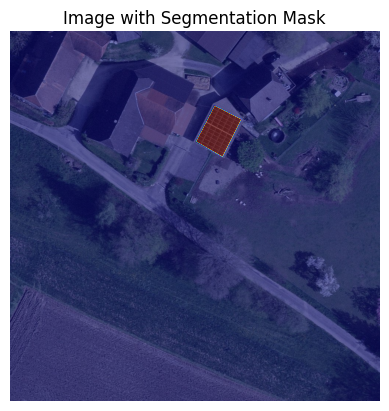

In [10]:
filled_image = "swissimage-dop10_2024_2628.7-1227.8.jpg"
filled_image_path = "../data/sample/1/" + filled_image
segmentation_mask = labels[filled_image]
plot_mask_on_image(filled_image_path, segmentation_mask)

Works well! Let's move on to the next step.

### Model

We will first use a **U-Net** model to segment the solar panels, since in the literature it has been shown to be very effective for this type of task. Let's start with defining our own `Dataset` class.

In [11]:
class SolarPanelDataset(Dataset):
    def __init__(
        self,
        image_dir: str,
        image_names: list[str],
        masks: list[np.ndarray],
        transform: Optional[torchvision.transforms.Compose] = None,
    ):
        self.image_dir = image_dir
        self.image_names = image_names
        self.masks = masks
        self.transform = transform

    def __len__(self) -> int:
        return len(self.image_names)

    def __getitem__(self, idx) -> Image.Image | np.ndarray:
        image_path = os.path.join(self.image_dir, self.image_names[idx])
        image = np.array(Image.open(image_path).convert("RGB")).astype(np.float32) / 255.0
        mask = self.masks[idx].reshape(1000, 1000).astype(np.float32)
        if self.transform:
            image = self.transform(image)
            mask = np.expand_dims(mask, axis=0)
        return image, mask

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
dataset = SolarPanelDataset("../data/sample/1/", image_names[:100], list(labels.values())[:100], transform=transform)

Now, let's instantiate a `DataLoader` object to load the data in batches.

In [13]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

We can now define the **U-Net** model. We will use the `torchvision` implementation of the U-Net model.

In [ ]:
import sys
sys.path.insert(0, '../src')
from unet import UNet

# class UNet(nn.Module):
#     def __init__(self):
#         super(UNet, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
#             nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
#         )
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
#             nn.ReLU(),
#             nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

Let's define the device on which we will run the model.

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


And let's train the model !

In [ ]:
model = UNet(n_channels=3, n_classes=2).to(device)
criterion = nn.BCELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 4
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, masks in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}", unit="batch"):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    print(f"Validation Loss: {val_loss/len(val_loader):.4f}")

In [ ]:
model.eval()


sample_image, sample_mask = dataset[4]
sample_image = sample_image.unsqueeze(0).to(device)
with torch.no_grad():
    predicted_output = model(sample_image)


input_image = sample_image.cpu().squeeze().permute(1, 2, 0)
if isinstance(sample_mask, np.ndarray):
    ground_truth_mask = torch.tensor(sample_mask)

ground_truth_mask = ground_truth_mask.cpu().squeeze()
predicted_mask = predicted_output.cpu().squeeze()

binary_predicted_mask = (predicted_mask > 0.05)

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
# Input image
axes[0].imshow(input_image)
axes[0].set_title("Input Image")
axes[0].axis('off')

# Ground truth mask
axes[1].imshow(ground_truth_mask, cmap="gray")
axes[1].set_title("Ground Truth Mask")
axes[1].axis('off')

# Predicted mask
axes[2].imshow(predicted_mask, cmap="gray")
axes[2].set_title("Predicted Mask")
axes[2].axis('off')

# Thresholded predicted mask
axes[3].imshow(binary_predicted_mask, cmap="gray")
axes[3].set_title("Thresholded Predicted Mask")
axes[3].axis('off');

## Using only roofs to remove background noise

Our model is not really good, let's try something else. We can use the output of the `prepare_masks.ipynb` notebook to only keep roofs in images, so that we can remove background noise. Let's load the masks.

In [28]:
mask_folder = "../data/mask/42"
mask_files = [f for f in os.listdir(mask_folder) if f.endswith('.png')]

masks = {}
for mask_file in mask_files:
    mask_path = os.path.join(mask_folder, mask_file)
    mask_image = Image.open(mask_path).convert("L")
    mask_array = np.array(mask_image) / 255.0
    masks[mask_file] = mask_array

Let's try our mask on the images.

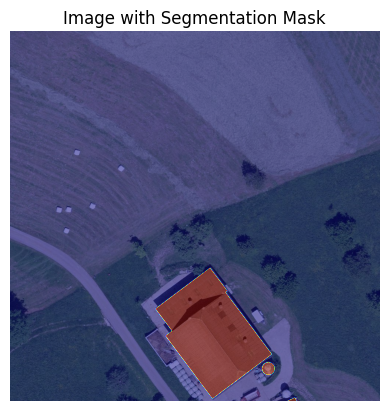

In [40]:
i = 1
input_path = f'../data/sample/42/{image_names[i]}'
mask = masks[image_names[i][:-4] + '.png']
plot_mask_on_image(input_path, mask)

Works well ! Let's define a function to modify our images, only keeping the roofs and making the rest of the image magenta.

In [23]:
def keep_roofs(
    image_name: str, 
    input_path: str,
    output_path: str,
    mask: np.ndarray, 
    color: list[int] = [255, 0, 255]
) -> None:
    """
    Overlay the mask on the image and keep only the pixels that are colored with the specified color.

    Args:
        image_name (str): The name of the image.
        input_path (str): The path to the image.
        output_path (str): The path to save the modified image.
        mask (np.ndarray): The mask to overlay on the image.
        color (list[int]): The color to keep, must be a 3-element list with the RGB values. Default is magenta, i.e. [255, 0, 255].
    
    Returns:
        PIL.Image: The image with only the pixels colored with the specified color.
    """
    image = Image.open(input_path + "/" + image_name)
    image_array = np.array(image)
    image_array[mask == 0] = color
    modified_image = Image.fromarray(image_array)
    modified_image.save(output_path + "/" + image_name) 

In [42]:
for name in tqdm(image_names):
    keep_roofs(name, "../data/sample/42", "../data/roofs/42", masks[name[:-4] + '.png'])

100%|██████████| 247/247 [00:06<00:00, 38.16it/s]


As a last sanity check, let's overlay the solar panels masks on top of the modified images.

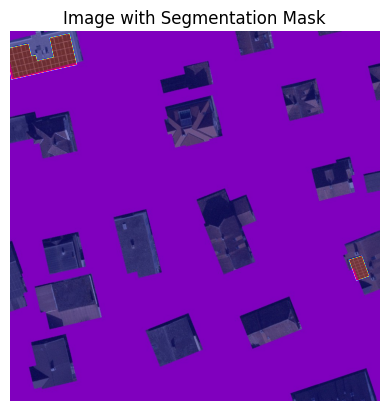

In [43]:
plot_mask_on_image(f'../data/roofs/42/{image_names[0]}', labels[image_names[0]])

Let's train our model again.

In [ ]:
dataset_v2 = SolarPanelDataset("../data/roofs/1/", image_names[:100], list(labels.values())[:100], transform=transform)

In [ ]:
train_dataset_v2, val_dataset_v2 = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_loader_v2 = DataLoader(train_dataset_v2, batch_size=8, shuffle=True)
val_loader_v2 = DataLoader(val_dataset_v2, batch_size=8)

In [ ]:
model = UNet().to(device)
criterion = nn.BCELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 4
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, masks in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}", unit="batch"):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    print(f"Validation Loss: {val_loss/len(val_loader):.4f}")

In [ ]:
model.eval()
sample_image, sample_mask = dataset_v2[15]
sample_image = sample_image.unsqueeze(0).to(device)
with torch.no_grad():
    predicted_output = model(sample_image)


input_image = sample_image.cpu().squeeze().permute(1, 2, 0)
if isinstance(sample_mask, np.ndarray):
    ground_truth_mask = torch.tensor(sample_mask)

ground_truth_mask = ground_truth_mask.cpu().squeeze()
predicted_mask = predicted_output.cpu().squeeze()


binary_predicted_mask = np.where(predicted_mask > 0.01, 1, 0)

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
# Input image
axes[0].imshow(input_image)
axes[0].set_title("Input Image")
axes[0].axis('off')

# Ground truth mask
axes[1].imshow(ground_truth_mask, cmap="gray")
axes[1].set_title("Ground Truth Mask")
axes[1].axis('off')

# Predicted mask
axes[2].imshow(predicted_mask, cmap="gray")
axes[2].set_title("Predicted Mask")
axes[2].axis('off')

# Thresholded predicted mask
axes[3].imshow(binary_predicted_mask, cmap="gray")
axes[3].set_title("Thresholded Predicted Mask")
axes[3].axis('off');